In [65]:
%config InlineBackend.figure_format = 'svg'
from IPython.display import Video
from IPython.display import HTML
import jax
import jax.numpy as jnp
import scipy
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['figure.figsize'] = (9, 6)
matplotlib.rcParams['image.cmap'] = 'summer'
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['legend.fontsize'] = 'large'
matplotlib.rcParams['figure.titlesize'] = 'medium'
matplotlib.rcParams['lines.linewidth'] = 2.0
import matplotlib.pyplot as plt
from celluloid import Camera

##### Machine Learning and Applications - Intro

### David Picard 
### École Nationale des Ponts et Chaussées
### david.picard@enpc.fr

# Resources

Books:

[Trevor Hastie, Robert Tibshirani, Jerome Friedman, The Elements of Statistical Learning: Data Mining, Inference, and Prediction.](https://web.stanford.edu/~hastie/ElemStatLearn/)

[Shai Shalev-Shwartz, Shai Ben-David, Understanding Machine Learning: From Theory to Algorithms](https://www.cs.huji.ac.il/~shais/UnderstandingMachineLearning/)*

[Kevin P. Murphy, Probabilistic Machine Learning: An Introduction](https://probml.github.io/pml-book/book1.html)

[Francis Bach, Learning Theory from First Principles](https://www.di.ens.fr/~fbach/ltfp_book.pdf)**

In French: [Chloé-Agathe Azencott, Introduction au Machine Learning](https://cazencott.info/index.php/pages/Introduction-au-Machine-Learning)

Other lectures at ENPC:
- Deep Learning, Stat en grande dimension

This lecture uses [JAX](https://jax.readthedocs.io) because I want to keep it investigate and look at how the algorithms work under the hood. In practice there are many high level libraries. Do not reinvent the wheel, but beware that some sell square wheels.

References can be found at the end of this book: <cite data-cite="hastie2009elements">(Hastie et al, 2009)</cite>, <cite data-cite="shalev2014understanding">(Shalev-Shwartz et al, 2014)</cite>, <cite data-cite="murphy2022probabilistic">(Murphy, 2022)</cite>, <cite data-cite="murphy2023probabilistic">(Murphy, 2023)</cite>, <cite data-cite="azencott2022introduction">(Azencott, 2022)</cite>.

# Setup

- Coupled random variables $X, y$ with unknown pdf $P(X, y)$, $P(X)$ or $P(y)$
- $X \in \mathcal{X}$ input domain
- $y \in \mathcal{Y}$ output domain

We want to find a function $f$ that approximates $y$ from $X$

In practice $X$ and $y$ can be anything for which we have good reasons to believe there is a relationship. For example, $X$ can be the location of a house and $y$ its value, or $X$ can be a press article and $y$ its political orientation. Note that it is not required that the link between $X$ and $y$ is a physical process (ex: $X$ is the characteristics of a steel cable and $y$ its tensile strength), or even that this link is causal ($X$ causes $y$, e.g., $X$ is a specific gene and $y$ an hereditary condition). We merely suggest that the two variables are _correlated_ and that there exists a function $f$ that captures that correlation to predict $y$ from $X$ with reasonable accuracy.

Please make sure that you understand correctly the big leap in methodology that has been made here: **we are no longer trying to explain to world by putting it into equations, we merely hypothesize that two phenomena are somehow related by a mechanism we have no interest in uncovering, but we aim at finding a function that is good enough at predicting one from the other**. There will never ever be any guarantee that our function $f$ is correct. **The best we can do is to find a function $f$ that has a satisfyingly low probability of error**.

## Expected Error

- To measure to quality of the approximation: loss function $l(f(x), y)$
  - example: $l(f(X), y) = 1$ if $f(X) \neq y, 0$ else
- Find $f$ that minimizes the average error

$$\mathbb{E}_{\sim X,y}[l(f(X), y)]$$



Recall the definition of the expectation:
$$\mathbb{E}_{\sim X,y}[l(f(X), y)] = \iint l(f(X), y) p(X,y) dX dy$$
This means that in our evaluation, we weight the error by the probability of sampling a couple $(X,y)$, and that the higher this probability, the higher we should consider that couple.

This formulation with the expectation is called _risk_, but there could be many other ways to aggregate the values of the loss function $l$ over all possible couples $(X,y)$. The risk has the benefit of being very intuitive, it means that _on average_ (with respect to the probability of observing $(X,y)$) $f$ does a certain loss.

## Two problems
1. $P(X,y)$ is unknown
  - Complex phenomenon, no explicit model

2. Finding a minimizer may be difficult
  - example: $l(f(X), y) = 1$ if $f(X) \neq y, 0$ else $\Rightarrow$ SAT problem, NP-hard

It is a little abusive to write here that the $0-1$ loss (as it is called) leads to a SAT problem in general. But it is nonetheless easy to see that if $\mathcal{X}$ is a countable set and the relationship between $X$ and $y$ is arbitrary, then minimizing the $0-1$ loss over that entire set require finding a function that satisfies a set of binary expressions. SAT is NP-Complete, meaning that solution can be found via brute force and verified in polynomial time, which is the hardest kind of problem that we can verify quickly.

# Empirical risk minimization
Solving problem #1, $P(X,y)$ is unknown:


If $P$ was known, we would use

$$f(x) = \arg\max_y P(y|x)$$

which is our best guess and would lead to the following error

$$P_e = \int \left(1 - \max_y P(y|x)\right)p(x)dx$$

(Bayes error)

This is the lowest achievable error rate.

- If the process is deterministic, then $\max_yP(y|x)=1$ and perfect prediction can be achieved.

- If the process is intrinsically random (*e.g.*, throw 2 dice, $x$ is the first dice, $y$ is the sum of the dice), then there is some irreducible error.

The Bayes error is worth keeping in mind because machine learning is, again, not about uncovering the golden equation that links $X$ to $y$ - which may not even exist - but to merely find a good enough way to predict $y$ from $X$. Because we do not make the assumption that there is an exact deterministic causal link, it is more than likely that this irreducible error exist. And as such, the best we can ever hope to do is approaching this irreducible error.

Estimate the error instead:

- Training set of examples $\mathcal{A} = \{(X_i, y_i)\}_{i\leq n}$ sampled from $P(X,y)$

- Approximate the expected error by the empirical risk

$$E(f) = \frac{1}{n} \sum_i l(f(X_i), y_i)$$

- Find $f$ that minimizes $E(f)$

$$ f^\star = \arg\min_f E(f)$$

Now we can see three of the four ingredients that define a machine learning system:
- A training set
- A loss function
- A family of function from which we have to select the one that minimizes the loss over the training set.

A quick note: the training set has to be sampled i.i.d. from $P(X,y)$ so that the average corresponds to the empirical estimator of the expectation. This is important because is gives a good hint that increasing the size of the training set is in the limit going to attain the true error.

## A Bad Example
Consider the function
$$ f(X) = \begin{cases}y_i\text{ if }\exists X_i \in \mathcal{A}\text{ such that }X_i = X \\ 0\text{ else}\end{cases}$$

Obviously
$$E(f) = 0$$

However, $f$ is pretty useless at predicting anything outside of $\mathcal{A}$

This example is very important, we should always have it in mind we thinking about a machine learning problem. It is both the best optimizer of the empirical risk one can find, and the most useless predictor. It highlights the blessing and the curse of machine learning: the blessing is that we make minimal assumptions about the phenomenon and we just need some data, the curse is that we only have these data and it is very easy to be mislead by them.

## A not-as-bad example

Points inside a random circle

In [66]:
def gt(x):
    x1 = x[:,0] > 0.
    x2 = x[:,0] < 0.8
    y1 = x[:,1] > 0.2
    y2 = x[:,1] < 0.8
    return 1*(x1 * x2 * y1 * y2)

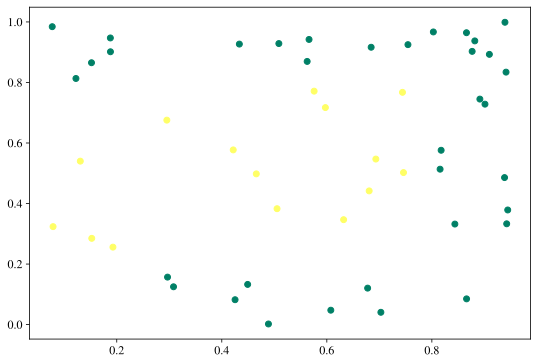

In [67]:
key = jax.random.PRNGKey(0)
key, skey = jax.random.split(key)
X = jax.random.uniform(skey, (50, 2))
y = gt(X)

plt.scatter(X[:,0], X[:,1], c=y)

In [68]:
class CirclePredictor:
    def __init__(self, key):
        key, skey = jax.random.split(key)
        self.c = jax.random.uniform(key, (2,))
        self.r = jax.random.uniform(skey)
    def __call__(self, X):
        return jnp.sign(1*((X[:,0] - self.c[0])**2 + (X[:,1] - self.c[1])**2 < self.r**2))

def loss(y_pred, y_true):
    return (1-(y_pred==y_true)).mean()

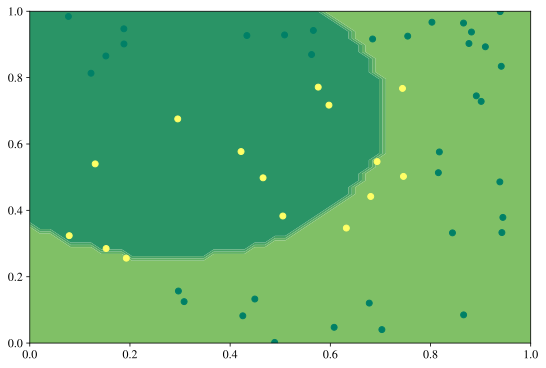

In [69]:
key, skey = jax.random.split(key)
pred = CirclePredictor(skey)

t = 50; tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = pred(xx).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels); plt.scatter(X[:,0], X[:,1], c=y)

## (Randomly) Searching for a good $f$

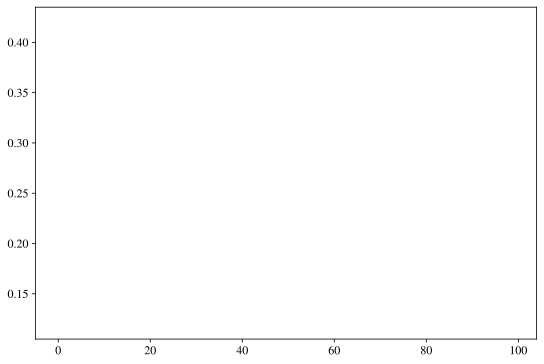

In [7]:
fig = plt.figure()
camera = Camera(fig)
key = jax.random.PRNGKey(7)
l_min = 20; f_best = None
le = []
for i in range(100):
    key, skey = jax.random.split(key)
    f = CirclePredictor(skey)
    l = loss(f(X), y)
    if l < l_min:
        l_min = l; f_best = f
    le.append(l_min)
    plt.plot(le, '-k'); camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())

## Are we lucky

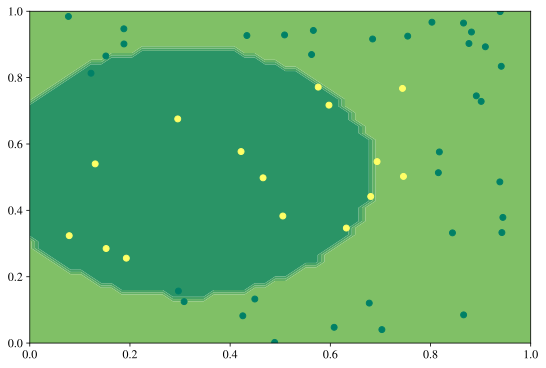

In [8]:
t = 50
tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = f_best(xx).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels)
plt.scatter(X[:,0], X[:,1], c=y)

# Generalization

- We know $f$ is good on $\mathcal{A}$ (at least better than other)
- We don't know if it's good on other samples


The difference between the expected risk and the empirical risk is know as the *generalization gap*

- A function that performs poorly on unseen data compared to training data is *overfitting*

How do we know if $f$ is overfitting?
- Measuring the error on $\mathcal{A}$ is not informative $\Rightarrow$ Split the examples into training and evaluation sets



Generalization is what differenciates machine learning from statistics with optimization. In statistics, we are not making prediction, we are making characterization and there is no generalization. In optimization, the optimal solution is the goal, but in machine learning we know the optimal solution can be pointless as what we really want is not a low error on the samples we already have, but a low error rate on the samples we do not have yet.

In some sense, one could say that machine learning consists in optimizing the wrong problem with the wrong model, and it is indeed exactly that! But it is the best problem we can optimize and we will use it to find out the best model we can, and it is already something better than nothing.

## Let's try

Check whether the error is the same on different sets of samples.

In [9]:
key = jax.random.PRNGKey(6)
Xt = jax.random.uniform(key, (50, 2))
yt = gt(Xt)

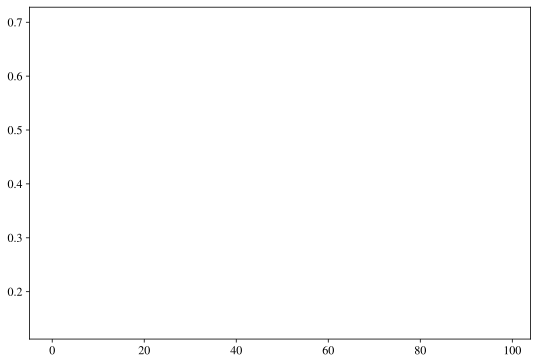

In [10]:
fig = plt.figure()
camera = Camera(fig)
key = jax.random.PRNGKey(1)
l_min = 20; f_best = None
le = []
lt = []
for i in range(100):
    key, skey = jax.random.split(key)
    f = CirclePredictor(skey)
    l = loss(f(X), y)
    if l < l_min:
        l_min = l; f_best = f
    le.append(l)
    lt.append(loss(f(Xt), yt))
    plt.plot(le, '-k'); plt.plot(lt, '-r'); camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())

Both errors are correlated (the contrary would be very worrying), but some extreme values may be very different. We are at the risk of selecting an $f$ because we were lucky.

# k-NN: A Better learning machine

$k$ nearest neighbor: prediction is a vote among $k$ nearest elements of the training set

Example $1-NN$:

$$f(x) = y_i \text{  s.t.  }  i = \arg\min_{x_j \in \mathcal{A}} \| x - x_j \|^2$$

- Memorizes the entire training set
- Does 0 empirical error on $\mathcal{A}$

$k$-NN is one of the oldest algorithm of machine learning (see <cite data-cite="cover1967nearest">(Cover, 1967)</cite> and <cite data-cite="pelillo2014alhazen">(Pelillo, 2014)</cite>), and certainly one of the most intuitive. Interestingly, it took much longer to formalize than more complicated methods (such as quadratic discriminant analysis). The key aspect of $k$-NN is that it is solely based on data: there is no model, nothing that tries to put the phenomenon in equation. The only assumption that we implicitely make is that the phenomenon has a topological property, \textit{id est}, that nearby $X$ in the sense of the chosen distance have similar $y$. In practice, this is often the case. Or to put it differently, if it were not the case and there is not regularity in the way $X$ and $y$ are related, then our chances of finding a good predictor are incredibly slim.

The training procedure of a $k$-NN is very simple, we just have to memorize the entire training set. This of course becomes increasingly costly as the training set size grows, but in practical terms, storage is not a very challenging issue.
Prediction is more problematic as it requires find the nearest neighbors which has a complexity linear with the size of the training set. There are approximate search tools that have become very effective, but it is nonetheless a burden that limits in practice the applicability of $k$-NN to large datasets.

In [70]:
class FirstNearestNeighbor:
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __call__(self, x):
        dist = ((self.X[None,:,:] - x[:,None,:])**2).sum(axis=2) # broadcast to B x n x dim
        index = jnp.argmin(dist, axis=1)
        return self.y[index]    

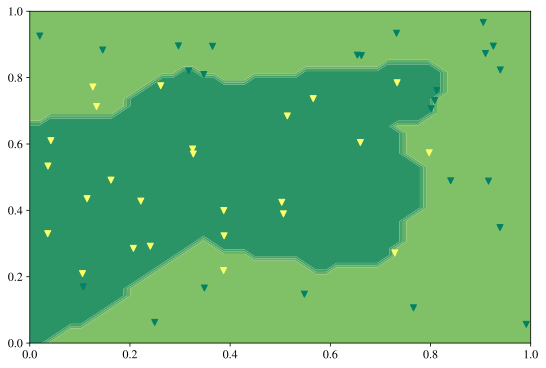

In [74]:
nn = FirstNearestNeighbor(X, y)
t = 50
tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = nn(xx).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels)
#plt.scatter(X[:,0], X[:,1], c=y)
plt.scatter(Xt[:,0], Xt[:,1], marker='v', c=yt)

## Generalization bound

What is the expected error of 1-NN in the limit?

Theorem <cite data-cite="cover1967nearest">(Cover & Hart, 1967)</cite>: Let X be a metric space. Let $p_1$ and $p_2$ be such that with probability 1, $x$ is either 1) a continuity point of $p_1$ and $p_2$, or 2) a point on non-zero probability measure. Then the NN risk R (probability of error) has the bounds:

$$R^\star \leq R \leq 2R^\star(1-R^\star)$$

With $R^\star$ the Bayes error (irreducible error) $R^\star = E[\min_j \sum_i p_i(x)L(i,j)]$.



#### Proof

Lemma: Let $x_n'$ denote the nearest neighbor of $x$ in the set $\{x_0, \dots, x_n\}$, then $x_n' \rightarrow x$ with probability one (continuity + point measure).

- Pointwise error: $r(x, x_n') = P[y=1|x]P[y'=2|x_n'] + P[y=2|x]P[y'=1|x_n'] = p_1(x)p_2(x_n') + p_2(x)p_1(x_n')$
- By lemma: $r(x, x_n') \rightarrow 2p_1(x)p_2(x) = 2p_1(x)(1-p_1(x))$
- Bayes pointwise error: $r^\star(x) = \min \{p_1(x), 1-p_1(x)\}$ (lowest probability or error)
- $r(x) \leq 2r^\star(x)(1-r^\star(x))$ and take the expectation over $x$: $R = E[2r^\star(x)(1-r^\star(x))]$
- $R = E[r^\star(x)]+E[r^\star(x)(1-2r^\star(x))]\geq E[r^\star(x)] = R^\star$
- $R = 2R^\star(1-R^\star)-2\text{Var}(r^\star(x))\leq 2R^\star(1-R^\star)$

## What is the effect of k?

We can increase the value $k$ to take more than the first neighbor into account when making prediction.

In [13]:
class KNearestNeighbor:
    def __init__(self, X, y, k=1):
        self.X = X
        self.y = y
        self.k = k
    def __call__(self, x):
        dist = ((self.X[None,:,:] - x[:,None,:])**2).sum(axis=2) # broadcast to B x n x dim
        indices = jnp.argsort(dist, axis=1)
        yp = 1*((self.y[indices[:,0:self.k]]).sum(axis=1) > self.k//2)
        return yp

(<matplotlib.collections.PathCollection at 0x74d4d85133a0>,
 <matplotlib.collections.PathCollection at 0x74d4d853abf0>)

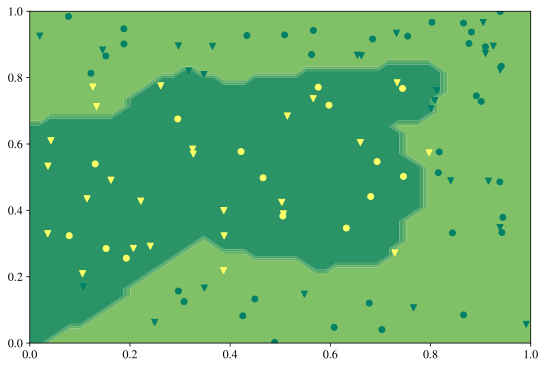

In [14]:
nn = KNearestNeighbor(X, y, k=1)
t = 50
tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = nn(xx).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels)
plt.scatter(X[:,0], X[:,1], c=y), plt.scatter(Xt[:,0], Xt[:,1], marker='v', c=yt)

(<matplotlib.collections.PathCollection at 0x74d4d8aacc10>,
 <matplotlib.collections.PathCollection at 0x74d4d8aea890>)

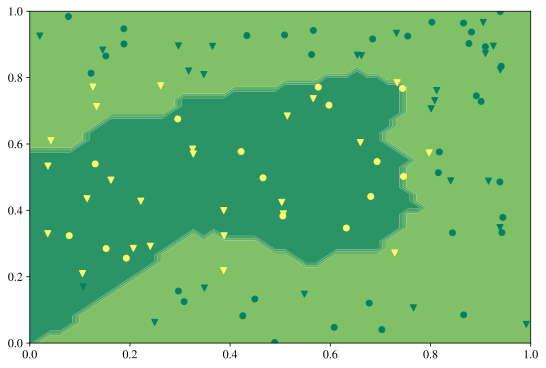

In [15]:
nn = KNearestNeighbor(X, y, k=2)
t = 50
tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = nn(xx).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels)
plt.scatter(X[:,0], X[:,1], c=y), plt.scatter(Xt[:,0], Xt[:,1], marker='v', c=yt)

(<matplotlib.collections.PathCollection at 0x74d4d9f0bd90>,
 <matplotlib.collections.PathCollection at 0x74d4d9f34df0>)

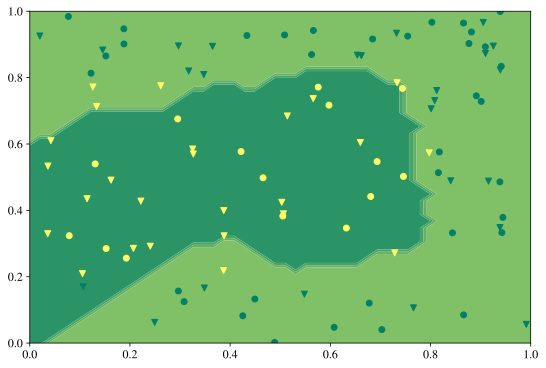

In [16]:
nn = KNearestNeighbor(X, y, k=3)
t = 50
tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = nn(xx).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels)
plt.scatter(X[:,0], X[:,1], c=y), plt.scatter(Xt[:,0], Xt[:,1], marker='v', c=yt)

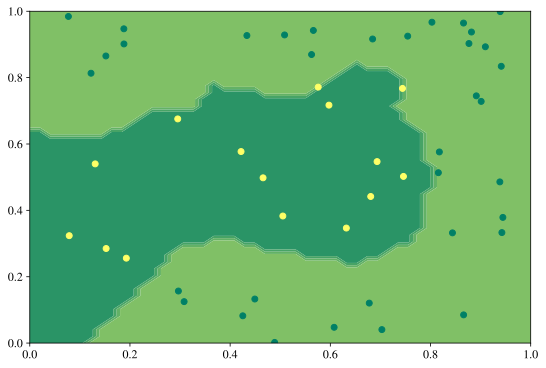

In [17]:
nn = KNearestNeighbor(X, y, k=5)
t = 50
tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = nn(xx).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels)
plt.scatter(X[:,0], X[:,1], c=y)#, plt.scatter(Xt[:,0], Xt[:,1], marker='v', c=yt)

## Model selection
How do we select k?
- They all do 0 error on $\mathcal{A}$

- We can split $\mathcal{A}$ in 2:

  - One for training each k-NN: *training* set
  
  - One for evaluating each k-NN: *validation* set
  
Since the validation set is used to select a model, it cannot be used to give us an idea of the expected risk



Standard 3-split procedure: *train, validation, test*

- Train on *train*

- Perform model selection on *validation*

- Evaluate on *test*


This is maybe the most important bit of methodology there is about machine learning in general. Because we are using data and only that for everything that we do, we have to be very careful to not use them twice or we inevitably get a biased result. We usually need data three times:
- During training to build our function $f$ (in the case of $k$-NN, we just memorize it).
- During model selection to select the best predictor among several algorithmic choices.
- During evaluation to estimate how good our selected model will perform in the wild.

It is of the utmost importance that one of these steps does not contaminate the others. For example, if training examples leak into the validation set, then it can change the outcome of model selection leading to selecting the wrong model. Similarly, if training examples leak into the test set (or \textit{vice versa}), then we will over-estimate the performances of the model.

We show below the error rates for various values of $k$, knowing that we can only look at the validation for selecting the best $k$, and then look at the test to estimate how it will perform in reality.

In [18]:
key = jax.random.PRNGKey(33)
Xv = jax.random.uniform(key, (50, 2))
yv = gt(Xt)

([<matplotlib.lines.Line2D at 0x74d4b9155f30>],
 [<matplotlib.lines.Line2D at 0x74d4b9156f50>])

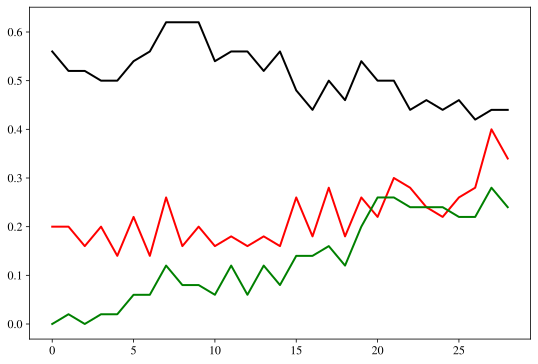

In [19]:
lv = []; lt = []; lr = []
for k in range(1,30):
    nn = KNearestNeighbor(X, y, k)
    lv.append(loss(nn(Xv), yv))
    lt.append(loss(nn(Xt), yt))
    lr.append(loss(nn(X), y))
plt.plot(lv, '-k'), plt.plot(lt, '-r'), plt.plot(lr, '-g')

(<matplotlib.collections.PathCollection at 0x74d4e40c3580>,
 <matplotlib.collections.PathCollection at 0x74d4b91f3ac0>)

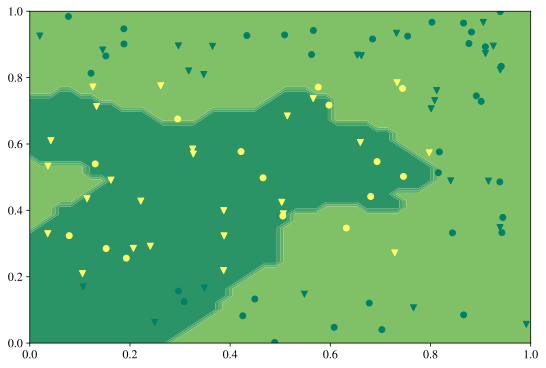

In [20]:
nn = KNearestNeighbor(X, y, k=17)
t = 50
tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = nn(xx).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels)
plt.scatter(X[:,0], X[:,1], c=y), plt.scatter(Xt[:,0], Xt[:,1], marker='v', c=yt)

# Statistical fluke?

Knowing that $f$ does $\epsilon$ expected error, what is the probability that $f$ has an empirical error of $\eta$ or less on a dataset of size $n$?

- Probability that $f$ does *exactly* $m$ error over $n$ samples
$$ {n \choose m} \epsilon^m (1-\epsilon)^{n-m} $$

- Probability that $f$ does $m$ or less error over $n$ samples
$$ \sum_{k=1}^m {n \choose k}\epsilon^k(1-\epsilon)^{n-k}$$

For $\eta$ observe error rate
$$ \sum_{k=1}^{\lfloor \eta n \rfloor}{n \choose k} \epsilon^k(1-\epsilon)^{n-k}$$

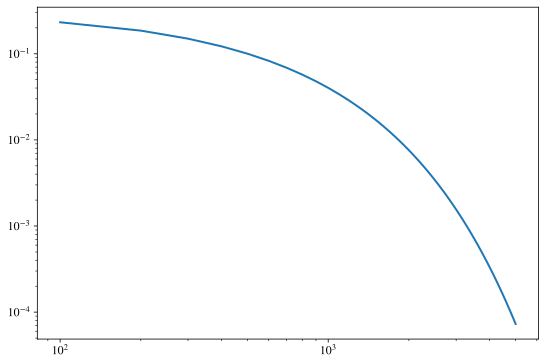

In [64]:
def Pn_of_eta_given_eps(n, eta, eps):
    p = 0
    for k in range(int(eta*n)):
        p += scipy.special.comb(n, k) * eps**k * (1-eps)**(n-k)
    return p
x = range(100, 5100, 100)
p = [Pn_of_eta_given_eps(i, 0.03, 0.04) for i in x]
plt.loglog(x, p)

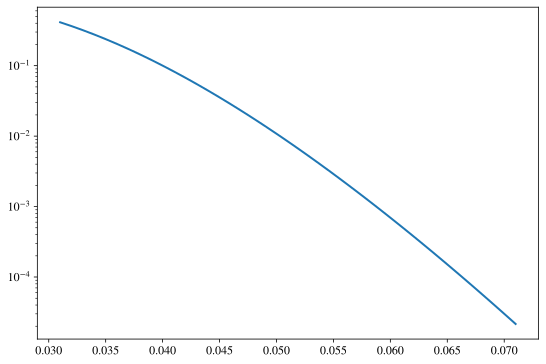

In [59]:
x = 0.031+0.001*jnp.arange(0, 41, 1)
p = [Pn_of_eta_given_eps(500, 0.03, i) for i in x]
plt.semilogy(x, p)

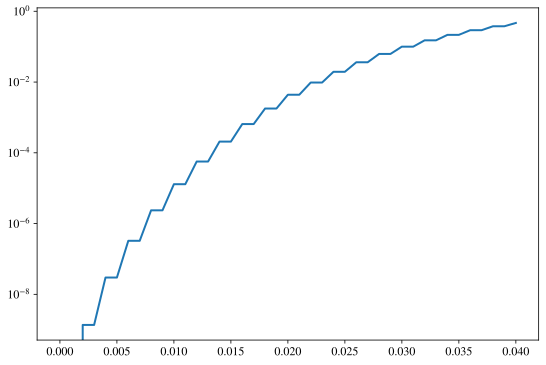

In [62]:
x = 0.001*jnp.arange(0, 41, 1)
p = [Pn_of_eta_given_eps(500, i, 0.04) for i in x]
plt.semilogy(x, p)

Although these small curves may not seem impressive, they are a reminder that there is always a chance that we get a specific training set that over- or under- estimates the actual error rate.

In a recent technical report, I showed that deep learning methods are sensitive to the choice of the pseudorandom number generator initialization (see \cite{picard2021torch}). Obvisouly, changing the random seed should not affect the results significantly, and if they do, it is only because we have sampled a specific training set that happens to be better for the model obtained with that particular seed. So instead of sampling training set, sampling random seeds achieves the same effect. In that report, I argue that most of the changes that are made during the development of a machine learning system have the same effect: they are inconsequential with respect to the problem and yet they may improve the results just because they correspond to sampling a new training set that may be a lucky one.

We should always keep that in mind. As D. Knuth put it in \emph{The Art of Computer Programming}, \emph{``premature optimization is the root of all evil''}, and the corresponding statement in machine learning would be that premature optimization of the error rate without proper validation and model selection is the root of all evil.

## Cross-validation

Split the data into several training-validation sets and average the error

- Random split: perform $r$ random splits of $x\%$ training $(1-x)\%$ validation (typically 80/20)

- K-fold: split in $k$ subsets and perform $k$ permutations $k-1$ sets for training, 1 set for validation

Select model that has lowest average validation error and evaluate on test

- Variance gives an idea of the relevance of the selection process

Cross validation is the proper way of developping a machine learning system. It takes into account the variability due to sampling a specific training set, and it gives a confidence associated to the error rate.

In [23]:
key = jax.random.PRNGKey(4) # chosen by a fair dice roll
X = jax.random.uniform(key, (100, 2))
y = gt(X)

In [24]:
def randomSplit(key, X, y, train_part=0.8):
    n = X.shape[0]
    n_train = int(train_part*n); n_test = n - n_train
    p = jax.random.permutation(key, n)
    X_train = X[p[0:n_train], :]; y_train = y[p[0:n_train]]
    X_val = X[p[n_train:],:] ; y_val = y[p[n_train:]]
    return X_train, y_train, X_val, y_val

<ErrorbarContainer object of 3 artists>

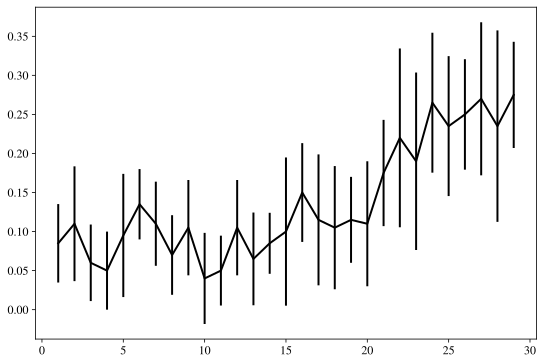

In [25]:
key = jax.random.PRNGKey(32)
l = []
for k in range(1, 30):
    lk = []
    for s in range(10):
        key, skey = jax.random.split(key)
        X_train, y_train, X_val, y_val = randomSplit(skey, X, y)
        nn = KNearestNeighbor(X_train, y_train, k=k)
        lk.append(loss(nn(X_val), y_val))
    l.append(lk)
l = jnp.asarray(l)
plt.errorbar(range(1,30), l.mean(axis=1), l.std(axis=1), fmt='-k')

## Full training
Once hyperparameters are selected, train on full training set, eval on test

(<matplotlib.collections.PathCollection at 0x77e707ae90c0>,
 <matplotlib.collections.PathCollection at 0x77e707b30850>)

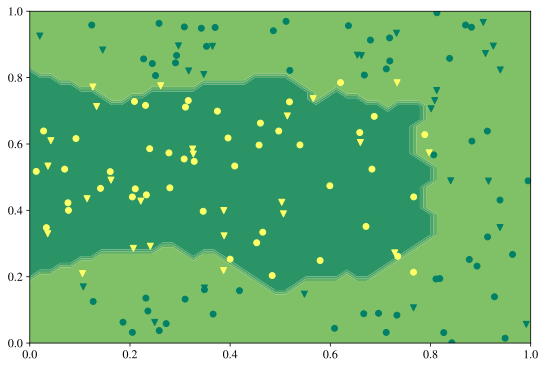

In [26]:
nn = KNearestNeighbor(X, y, k=4)
t = 50
tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = nn(xx).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels)
plt.scatter(X[:,0], X[:,1], c=y), plt.scatter(Xt[:,0], Xt[:,1], marker='v', c=yt)

## Conclusion on validation in ERM
- Low training error does not imply generalization (*e.g.*, $k$-NN)
- A single run training/validation can just be lucky
- Model selection using cross-validation
- Final performance evaluation on a test set

# Finding $f$ is hard
Solving problem #2, finding a good $f$ is hard:

- 0-1 loss is difficult to optimize, alternatives?

The main idea is to find a proxy for the 0-1 loss that is easier to optimize, for example something that leads to a well known optimization problem. Idealy, we want the proxy to upper-bound the 0-1 loss because then we known that the true error rate (the 0-1 loss) is below the attained value, but in practice it is not always required because even if we cannot easily optimize the 0-1 loss, we can however measure it and make sure that the solution to the optimization problem is indeed good in terms of error rate even without theoretical guarantees.

## Regression
- $\mathcal{Y}$ is continuous
$$MSE: (y - f(X))^2, \quad MAE: |y - f(x)|$$
- Vector case: any norm of $y - f(X)$

This is probably the most used form of approximation of the 0-1 loss, but it makes one very important hidden assumption in that it considers some structure for $\mathcal{Y}$. Indeed, by assuming that we can use some metric to measure the error, we implicitly say that some targets $y$ are closer together, which may not always be the case.

## Classification
- $\mathcal{Y}$ is categorical $\rightarrow$ continuous relaxation, then decision with $\text{sign}(f(X))$
- Simple binary case: $\mathcal{Y} = \{-1 ; 1\}$
  - hinge loss: $\max(0, 1 - yf(X))$
  - log loss: $\log(1 + e^{-yf(X)})$
  - exp loss: $e^{-yf(X)}$

Classification is the other big category of learning and in contrast to regression it does not make an assumption about $\mathcal{Y}$. However, since elements in $\mathcal{Y}$ cannot be ordered, we have to design loss functions that will introduce an ordering such that we can perform the optimization. We show below the shape of popular loss functions.

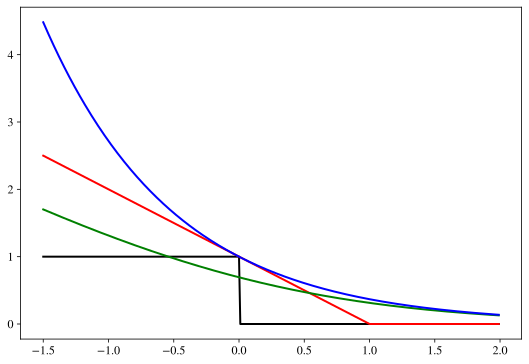

In [27]:
t = jnp.arange(-1.5, 2, 0.01)
plt.plot(t, 1-(jnp.sign(t)==1), '-k')
plt.plot(t, jnp.maximum(0, 1 - t), '-r')
plt.plot(t, jnp.log(1+jnp.exp(-t)), '-g')
plt.plot(t, jnp.exp(-t), '-b')

## Turning ERM into an optimization problem
Ellipse classifier with parameter $c_1, c_2, a, b$:
$$ f(X) = 1 - (a(X_1 - c_1)^2 +b(X_2 - c_2)^2)$$
In matrix form
$$f(X) = 1 - (X-C)^TA(X-C)$$

Using MSE
$$\min_{A, C} \sum_x (y - 1 + (x-C)^TA(x-C))^2$$

- Use optimization formulation to get closed form solution (*e.g.*, KKT)
- Use optimization techniques to get approximate solution (*e.g.*, interior points, cutting planes)
- Use gradient descent (it always gets you a better solution than random)

In [28]:
def mse(y_hat, y):
    return ((y-y_hat)**2).mean()

def circle(x, a, c):
    xc = x - c[None, :] # broadcast to n x 2
    return 1 - (a*xc**2).sum(1) # sum on axis=1

def loss(a, c, x, y):
    y_hat = circle(x, a, c)
    return mse(y_hat, y)

@jax.jit
def update(a, c, x, y):
    da, dc = jax.grad(loss, argnums=(0,1))(a, c, x, y)
    return a - 0.1 * da, c - 0.1 * dc

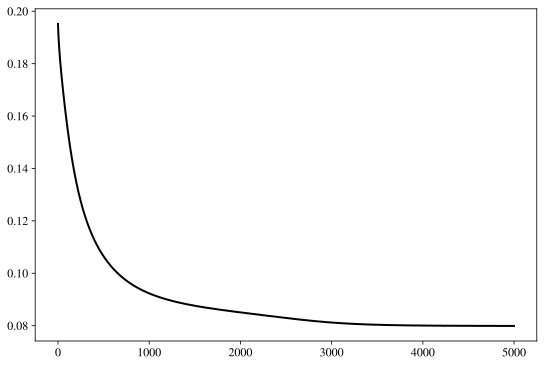

In [29]:
key = jax.random.PRNGKey(32)
key, skey = jax.random.split(key)
c = jax.random.uniform(key, (2,))
a = jnp.ones(2)
l = []
for t in range(5000):
    a, c = update(a, c, X, y)
    l.append(loss(a, c, X, y))
plt.plot(l, '-k')
    

(<matplotlib.collections.PathCollection at 0x77e707740d30>,
 <matplotlib.collections.PathCollection at 0x77e707741180>)

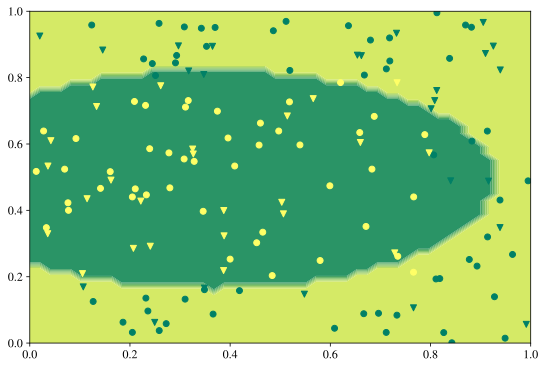

In [30]:
t = 50
tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = jnp.sign(circle(xx, a, c)-0.5).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels)
plt.scatter(X[:,0], X[:,1], c=y), plt.scatter(Xt[:,0], Xt[:,1], marker='v', c=yt)

Rectangle $\rightarrow$ switch from $\ell_2$ to $\ell_\infty$ norm

$$ f(X) = 1 - \max(a(X_1 - c_1)^2, b(X_2 - c_2)^2)$$

In [31]:
def square(x, a, c):
    xc = x - c[None, :] # broadcast to n x 2
    return 1 - (a*xc**2).max(1) # inf norm

def loss(a, c, x, y):
    y_hat = square(x, a, c)
    return mse(y_hat, y)

@jax.jit
def update(a, c, x, y):
    da, dc = jax.grad(loss, argnums=(0,1))(a, c, x, y)
    return a - 0.1 * da, c - 0.1 * dc

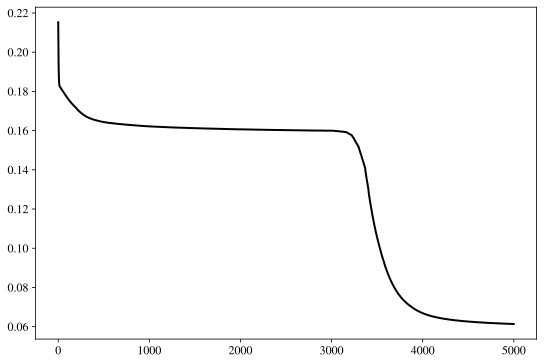

In [32]:
key = jax.random.PRNGKey(32)
key, skey = jax.random.split(key)
c = jax.random.uniform(key, (2,))
a = jnp.ones(2)
l = []
for t in range(5000):
    a, c = update(a, c, X, y)
    l.append(loss(a, c, X, y))
plt.plot(l, '-k')

A quick note on that staircase shaped curve: this is often the case with bad problems. In this case, it is because of the infinite norm which has gradient only on the worst offending coordinate, so we can only optimize the axes one at a time meaning that the error due to the others axes will remain until they become the highest.
There is nothing wrong with that, but remember that everytime the is a $\text{max}$ in a gradient descent, it means that the optimization will be sequential with respect to the coordinates and thus is likely to be very slow.

(<matplotlib.collections.PathCollection at 0x77e707d07730>,
 <matplotlib.collections.PathCollection at 0x77e707a5b790>)

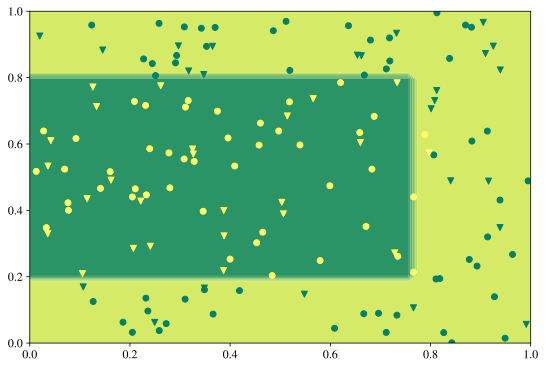

In [33]:
t = 50
tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = jnp.sign(square(xx, a, c)-0.5).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels)
plt.scatter(X[:,0], X[:,1], c=y), plt.scatter(Xt[:,0], Xt[:,1], marker='v', c=yt)

# Exercise

- Perform cross validation on the square classifier to set the number of optimization steps
- Plot train and val losses over time with errorbars

In [34]:
def RandomSplitCV(key, X, y, cls_func, max_steps=10000):
    # get a random 80% split of X,y
    # optimize a,c using cls_func for max_steps
    # keep track of training loss and validation loss
    return l_train, l_val

In [ ]:
# perform 10 random split CV
key = jax.random.PRNGKey(67)
# l_train = jax.random.uniform(key, (10000, 10)); l_val = 0.2*l_train

# plot train and val loss
x = jnp.arange(10000)
l_mean = l_train.mean(axis=1); l_std = l_train.std(1)
plt.plot(x, l_mean, '-b'); plt.fill_between(x, l_mean, l_mean-l_std, l_mean+l_std, color='b', alpha=0.5)
l_mean = l_val.mean(axis=1); l_std = l_val.std(1)
plt.plot(x, l_mean, '-r'); plt.fill_between(x, l_mean, l_mean-l_std, l_mean+l_std, color='r', alpha=0.5)

# Conclusion on ML and optimization
- Optimizing the 0-1 loss is really hard
- Regression is easy to set (continuous target, continuous $f$, standard optimization problem)
- Classification: relax to continuous $f$, find proxy loss (*e.g.*, hinge, logistic)

- Any classification problem can be cast as a regression by arbitrarily mapping $\mathcal{Y}$ to $\mathbb{R}$

- Regression is harder to train than classification (harder to generalize)
- Any regression problem can be transformed into a classification problem by quantizing $\mathcal{Y}$ (but you lose the topology of $\mathcal{Y}$)

## ML taxonomy

 - Supervised vs Unsupervised
 
   - Supervised: $y$ is known, effective, difficult to have data
   - Unsupervised: $y$ is unknown, difficult problem, easy to obtain data
   - Semi-supervised: mix of both
   - Reinforcement learning: supervised but only after $k$ decision steps
   

 - Online vs Batch:
 
   - Batch: train once on all data
   - Online: train on stream of data, then freeze the model
   - Continuous learning: train on steam, never freeze the model
   

- Passive vs Active:
    - Passive: all training data are i.i.d.
    - Active: training data obtained via a selection process to be more efficient

- Shallow vs Deep
  - Shallow learning: handcrafted/engineered features + ML based decision
  - Deep learning: train both feature extractor and decision

# Lecture 1's take home
- ERM principle
- *train/val/test* mantra, cross-validation
- ML is optimizing parameters to fit data
- Taxonomy: supervised/unsupervised, classification/regression
- Our first learning algorithm: $k$-NN!